In [ ]:
import os
import cv2
import zipfile
from tqdm import tqdm
from io import BytesIO
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CK+48.zip to CK+48.zip


In [ ]:
zip_path = next(iter(uploaded))
with zipfile.ZipFile(BytesIO(uploaded[zip_path]), 'r') as zip_ref:
    zip_ref.extractall("/content/CK+48")
extracted_path = "/content/CK+48/CK+48"
os.listdir(extracted_path)
DATADIR = extracted_path
CATEGORIES = os.listdir(DATADIR)

In [ ]:
def load_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])

    return data

In [ ]:
data = load_data()
len(data)

100%|██████████| 84/84 [00:00<00:00, 9037.59it/s]


981

In [ ]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))
X_train_Gabor  = X_train
X_test_Gabor = X_test
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train_SVM = y_train
y_test_SVM = y_test
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

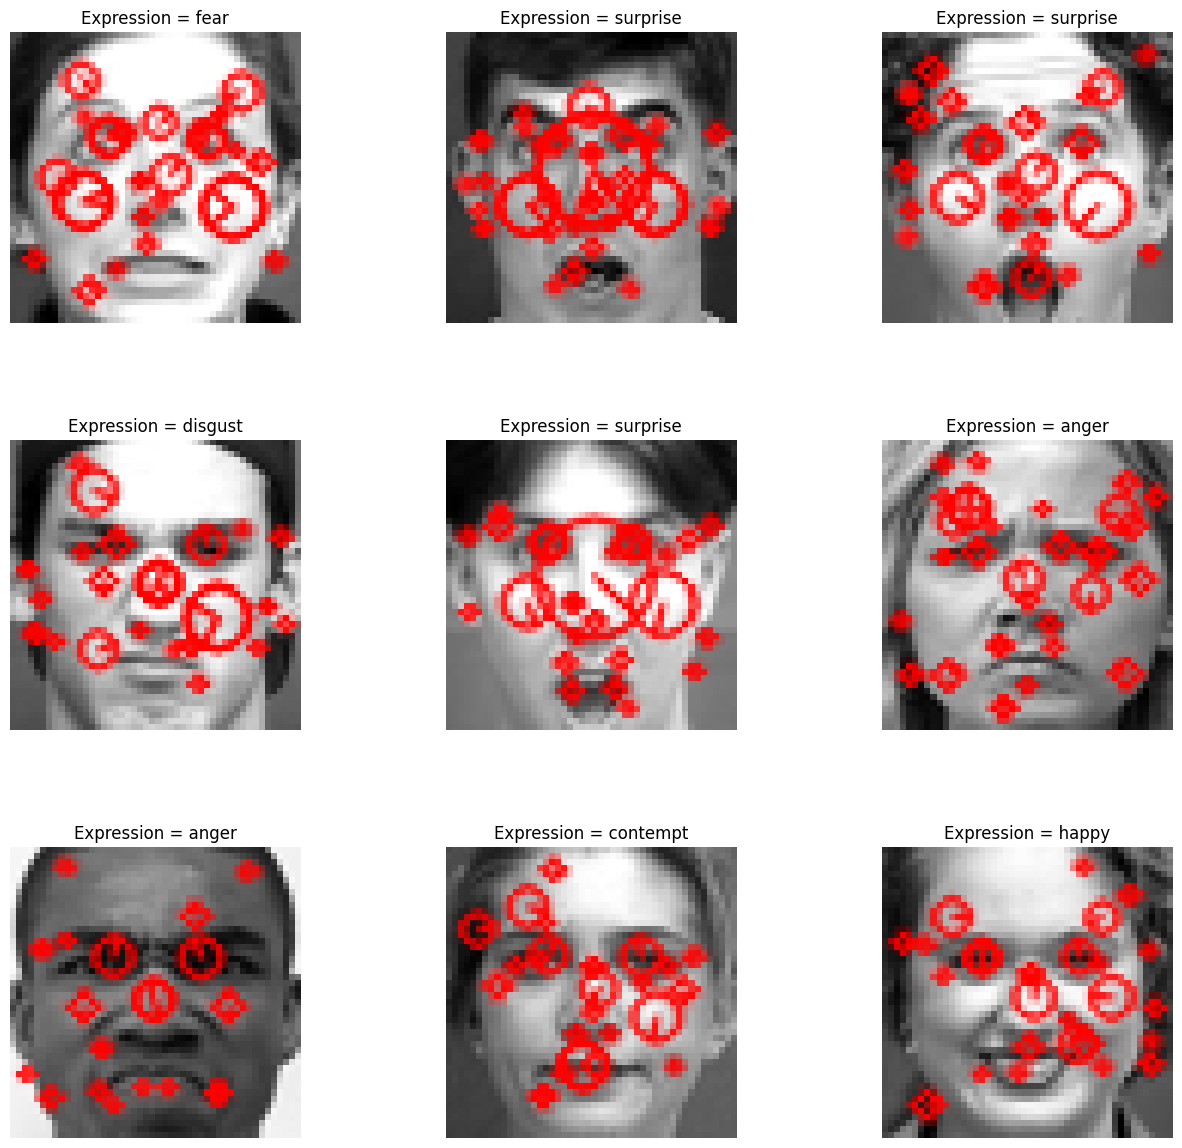

In [ ]:
L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):
    sample = random.choice(data)
    image8bit = cv2.normalize(sample[0], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image8bit,None)

    img = cv2.drawKeypoints(image=image8bit, outImage=sample[0], keypoints = kp, flags = 4, color = (255, 0, 0))
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [ ]:
img.shape

(48, 48, 3)

In [ ]:
def create_SIFT_features(data):
    Feature_data = np.zeros((len(data),48,48,3))

    for i in range(len(data)):
        img = data[i]
        image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(image8bit,None)

        img = cv2.drawKeypoints(image=image8bit, outImage=img, keypoints = kp, flags = 4, color = (255, 0, 0))
        Feature_data[i] = img/255.0


    return Feature_data

In [ ]:
X_train_SIFT = create_SIFT_features(X_train)
X_train_SIFT.shape

(784, 48, 48, 3)

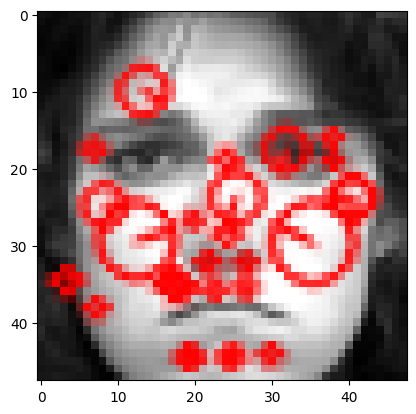

In [ ]:
plt.imshow(X_train_SIFT[0], cmap='gray')

In [ ]:
X_test_SIFT = create_SIFT_features(X_test)
X_test_SIFT.shape

(197, 48, 48, 3)

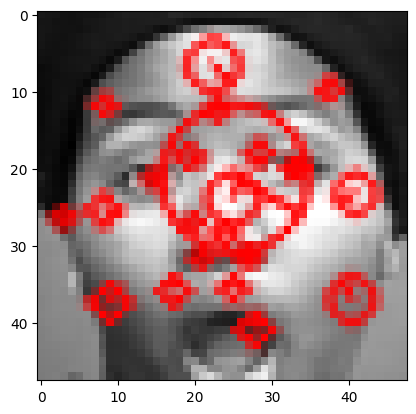

In [ ]:
plt.imshow(X_test_SIFT[0], cmap='gray')

In [ ]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    return model

es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [ ]:
SIFT_model = create_model(input_shape=(48,48,3))
SIFT_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [ ]:
SIFT_history = SIFT_model.fit(X_train_SIFT, y_train, batch_size=8 , epochs=50, validation_data = (X_test_SIFT, y_test),  callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 5s 41ms/step - loss: 1.8045 - accuracy: 0.3036 - val_loss: 1.7001 - val_accuracy: 0.3959 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 4s 37ms/step - loss: 1.3587 - accuracy: 0.5179 - val_loss: 1.2512 - val_accuracy: 0.5838 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 5s 46ms/step - loss: 1.0303 - accuracy: 0.6097 - val_loss: 0.8597 - val_accuracy: 0.6904 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 6s 58ms/step - loss: 0.7591 - accuracy: 0.7423 - val_loss: 0.6375 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 6s 64ms/step - loss: 0.5590 - accuracy: 0.7934 - val_loss: 0.4620 - val_accuracy: 0.8579 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 3s 30ms/step - loss: 0.4166 - accuracy: 0.8469 - val_loss: 0.3421 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 3s 26ms/step - loss: 0.3

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

In [ ]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

In [ ]:
# Make predictions
y_pred = np.argmax(SIFT_model.predict(X_test_SIFT), axis=1)
y_test_labels = np.argmax(y_test, axis=1)
classification_rep = classification_report(y_test_labels, y_pred)
print("Classification Report:\n", classification_rep)


7/7 [==============================] - 0s 46ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        38
           4       0.86      1.00      0.92        12
           5       1.00      0.96      0.98        51
           6       0.93      1.00      0.96        13

    accuracy                           0.98       197
   macro avg       0.97      0.99      0.98       197
weighted avg       0.99      0.98      0.99       197



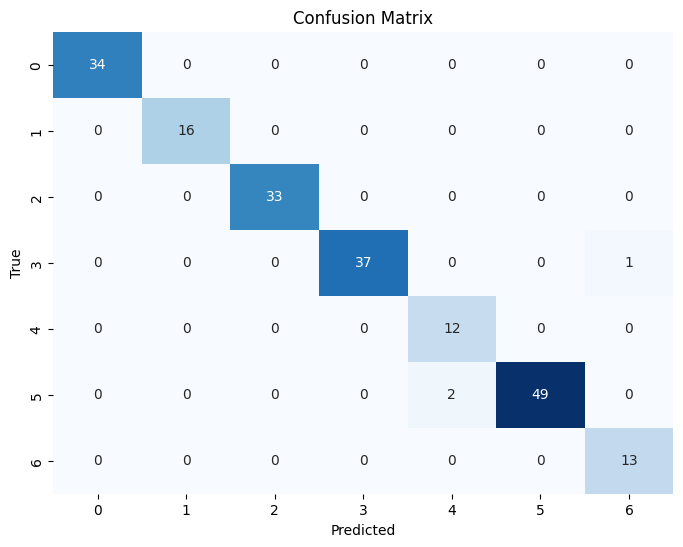

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test_labels), yticklabels=np.unique(y_test_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


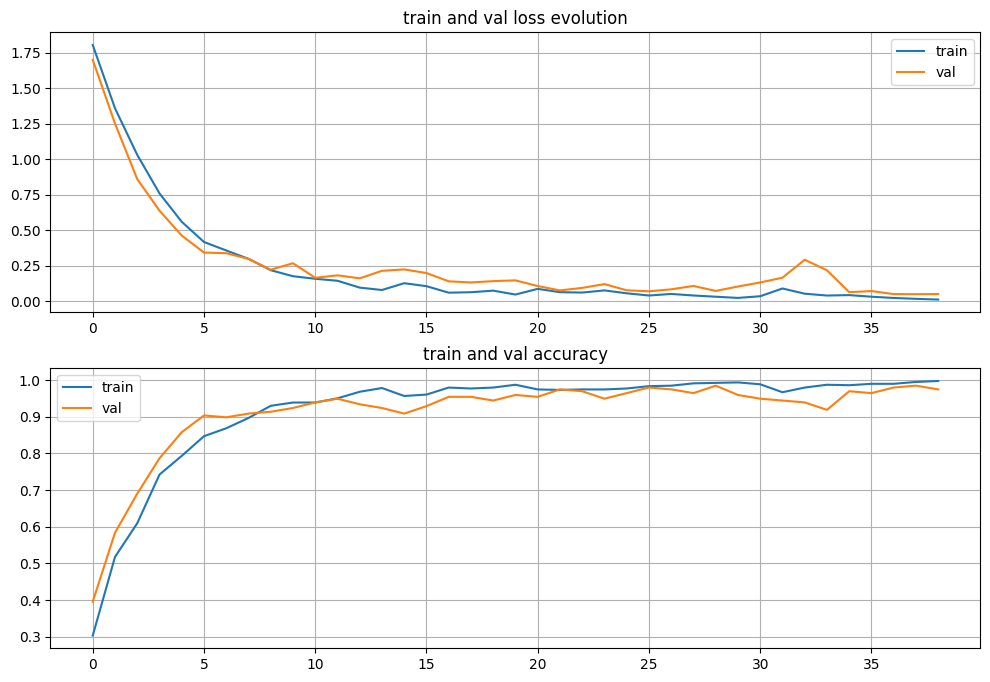

In [ ]:
plot_performance(SIFT_history)

In [ ]:
print("SIFT Accuracy :",SIFT_model.evaluate(X_test_SIFT, y_test, verbose = 0)[1])

SIFT Accuracy : 0.9847715497016907


In [ ]:
SIFT_model.save('SIFT_model.keras')